# Check tightness in real data

In [1]:
import logging
import os
import os.path as osp
import pickle

import networkx as nx
import numpy as np
from ogw.gw_lb import tlb
from ogw.ogw_dist import ogw_lb, ogw_ub, ogw_o
from ogw.utils import load_pyg_data
from joblib.parallel import Parallel, delayed
from ot.gromov import gromov_wasserstein
from torch_geometric.datasets import TUDataset
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
logging.basicConfig(format='%(asctime)s - %(message)s ', level=logging.INFO)

/home/hjin/miniconda3/envs/ogw_dev/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# replace your ROOT path
ROOT = osp.join(osp.expanduser("~"), 'tmp', 'data', "TUDataset")
dsname = "MUTAG"

# prepare dataset
Gs, ys = load_pyg_data(dsname)
Cs = [np.array(nx.floyd_warshall_numpy(g)) for g in Gs]
Ns = [C.shape[0] for C in Cs]
ps = [np.ones(n) / n for n in Ns]

SAVED_PATH = osp.join(ROOT, dsname, "saved")
if not osp.isdir(SAVED_PATH):
    logging.info("creating folder")
    os.makedirs(SAVED_PATH)

N = len(Gs)




In [3]:
# calculate pairwise distance in parallel

def calc_D_GW(i, j, D):
    T, gw_log = gromov_wasserstein(Cs[i], Cs[j], ps[i], ps[j], loss_fun="square_loss", log=True)
    D[i, j] = gw_log['gw_dist']


def calc_D_GW_tlb(i, j, D):
    D[i, j] = tlb(Cs[i], Cs[j])


def calc_D_OGW_lb(i, j, D):
    D[i, j] = ogw_lb(Cs[i], Cs[j])


def calc_D_OGW_ub(i, j, D):
    D[i, j] = ogw_ub(Cs[i], Cs[j])

def calc_D_OGW_o(i, j, D):
    D[i, j] = ogw_o(Cs[i], Cs[j])

# GW
path_to_file = osp.join(SAVED_PATH, "D_GW.pkl")
if osp.exists(path_to_file):
    D_GW = pickle.load(open(path_to_file, "rb"))
else:
    fn_mm = osp.join(ROOT, dsname, "D_GW")
    D_GW = np.memmap(fn_mm, mode="w+", shape=(N, N), dtype=float)

    logging.info(f"calcualte GW")
    Parallel(n_jobs=-1, backend="multiprocessing")(
        delayed(calc_D_GW)(i, j, D_GW) for i in range(N) for j in range(i + 1, N))
    D_GW += D_GW.T

    pickle.dump(D_GW, open(osp.join(SAVED_PATH, "D_GW.pkl"), "wb"))

# GW_tlb
path_to_file = osp.join(SAVED_PATH, "D_GW_tlb.pkl")
if osp.exists(path_to_file):
    D_GW_tlb = pickle.load(open(path_to_file, "rb"))
else:
    fn_mm = osp.join(ROOT, dsname, "D_GW_tlb")
    D_GW_tlb = np.memmap(fn_mm, mode="w+", shape=(N, N), dtype=float)

    logging.info(f"calcualte GW")
    Parallel(n_jobs=-1, backend="multiprocessing")(
        delayed(calc_D_GW_tlb)(i, j, D_GW_tlb) for i in range(N) for j in range(i + 1, N))
    D_GW_tlb += D_GW_tlb.T

    pickle.dump(D_GW_tlb, open(osp.join(SAVED_PATH, "D_GW_tlb.pkl"), "wb"))


# OGW_lb
path_to_file = osp.join(SAVED_PATH, "D_OGW_lb.pkl")
if osp.exists(path_to_file):
    D_OGW_lb = pickle.load(open(path_to_file, "rb"))
else:
    fn_mm = osp.join(ROOT, dsname, "D_OGW_lb")
    D_OGW_lb = np.memmap(fn_mm, mode="w+", shape=(N, N), dtype=float)

    logging.info(f"calcualte GW")
    Parallel(n_jobs=-1, backend="multiprocessing")(
        delayed(calc_D_OGW_lb)(i, j, D_OGW_lb) for i in range(N) for j in range(i + 1, N))
    D_OGW_lb += D_OGW_lb.T

    pickle.dump(D_OGW_lb, open(osp.join(SAVED_PATH, "D_OGW_lb.pkl"), "wb"))

# OGW_ub
path_to_file = osp.join(SAVED_PATH, "D_OGW_ub.pkl")
if osp.exists(path_to_file):
    D_OGW_ub = pickle.load(open(path_to_file, "rb"))
else:
    fn_mm = osp.join(ROOT, dsname, "D_OGW_ub")
    D_OGW_ub = np.memmap(fn_mm, mode="w+", shape=(N, N), dtype=float)

    logging.info(f"calcualte GW")
    Parallel(n_jobs=-1, backend="multiprocessing")(
        delayed(calc_D_OGW_ub)(i, j, D_OGW_ub) for i in range(N) for j in range(i + 1, N))
    D_OGW_ub += D_OGW_ub.T

    pickle.dump(D_OGW_ub, open(osp.join(SAVED_PATH, "D_OGW_ub.pkl"), "wb"))


# OGW_o
path_to_file = osp.join(SAVED_PATH, "D_OGW_o.pkl")
if osp.exists(path_to_file):
    D_OGW_o = pickle.load(open(path_to_file, "rb"))
else:
    fn_mm = osp.join(ROOT, dsname, "D_OGW_o")
    D_OGW_o = np.memmap(fn_mm, mode="w+", shape=(N, N), dtype=float)

    logging.info(f"calcualte GW")
    Parallel(n_jobs=-1, backend="multiprocessing")(
        delayed(calc_D_OGW_o)(i, j, D_OGW_o) for i in range(N) for j in range(i + 1, N))
    D_OGW_o += D_OGW_o.T

    pickle.dump(D_OGW_o, open(osp.join(SAVED_PATH, "D_OGW_o.pkl"), "wb"))


Text(0, 0.5, 'Density')

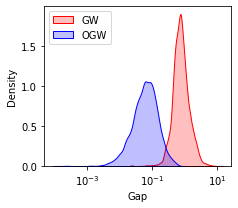

In [4]:
# plot
GW_diff = np.abs(np.triu(D_GW - D_GW_tlb, k=1))
OGW_diff = np.abs(np.triu(D_OGW_ub - D_OGW_lb, k=1))
# OGW_diff2 = np.abs(np.triu(D_OGW_ub - D_OGW_o, k=1))
fig = plt.figure(figsize=(3.5, 3), tight_layout=True)
sns.kdeplot(GW_diff[GW_diff > 1e-4].flatten(), shade=True, color="r", label="GW", log_scale=True)
sns.kdeplot(OGW_diff[OGW_diff > 1e-4].flatten(), shade=True, color="b", label="OGW", log_scale=True)
# sns.kdeplot(OGW_diff2[OGW_diff2 > 1e-4].flatten(), shade=True, color="g", label="OGW", log_scale=True)
# plt.legend(loc="lower left",
#            ncol=2,
#            prop={'size': 7},
#            bbox_to_anchor=(0., 1.02, 1., .2),
#            mode="expand")
plt.legend(loc="upper left")
plt.xlabel("Gap")
plt.ylabel("Density")
# plt.savefig("gap_MUTAG.pdf")